## Do not forget to click Edit -> Notebook settings -> Hardware accelerator ->GPU

<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2019/blob/master/06_lab/baseline_kaggle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As before - mount drive, download data

In [0]:
DATA_PREFIX = "/content/gdrive/My Drive/kaggle_2/"

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!mkdir /content/.kaggle
!cp /content/gdrive/My\ Drive/kaggle.json /content/.kaggle/
!chmod 600 /content/.kaggle/kaggle.json
!ls -l /content/.kaggle

%env KAGGLE_CONFIG_DIR=/content/.kaggle

total 4
-rw------- 1 root root 63 Feb  4 21:52 kaggle.json
env: KAGGLE_CONFIG_DIR=/content/.kaggle


In [6]:
!kaggle competitions download --force -c icl2019-jet -p '{DATA_PREFIX}'

!unzip '{DATA_PREFIX}/kaggle_train.h5.zip' -d '{DATA_PREFIX}'
!chmod +rw '{DATA_PREFIX}/kaggle_train.h5'
!rm '{DATA_PREFIX}/kaggle_train.h5.zip'


!unzip '{DATA_PREFIX}/kaggle_test.h5.zip' -d '{DATA_PREFIX}'
!chmod +rw '{DATA_PREFIX}/kaggle_test.h5'
!rm '{DATA_PREFIX}/kaggle_test.h5.zip'

100% 979M/982M [00:07<00:00, 126MB/s]
100% 982M/982M [00:08<00:00, 129MB/s]
100% 327M/329M [00:03<00:00, 123MB/s]
100% 329M/329M [00:03<00:00, 108MB/s]
Archive:  /content/gdrive/My Drive/kaggle_2//kaggle_train.h5.zip
replace /content/gdrive/My Drive/kaggle_2/kaggle_train.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/gdrive/My Drive/kaggle_2/kaggle_train.h5  
Archive:  /content/gdrive/My Drive/kaggle_2//kaggle_test.h5.zip
  inflating: /content/gdrive/My Drive/kaggle_2/kaggle_test.h5  


In [7]:
!ls '{DATA_PREFIX}'

kaggle_test.h5	kaggle_train.h5  nn_snapshots


In [8]:
import os
# Create folder to save NN snapshots during training
os.mkdir(os.path.join("/content/gdrive/My Drive/kaggle_2", "nn_snapshots"))

FileExistsError: ignored

# !Link to challenge!

# https://www.kaggle.com/t/bd1e8764a756429b941df45ce9457632

# Util functions to preprocess and work with data

In [0]:
def read_data(data, is_train=True, start_ind=0, end_ind=0):
    layer_hcal = np.expand_dims(data['all_events']['histHCAL'][start_ind : end_ind], -1).astype(np.float32)
    layer_em = np.expand_dims(data['all_events']['histEM'][start_ind : end_ind], -1).astype(np.float32)
    layer_track = np.expand_dims(data['all_events']['histtrack'][start_ind : end_ind], -1).astype(np.float32)
    
    hit_map = np.concatenate((layer_hcal, layer_em, layer_track), axis=-1).astype(np.float32)
    hit_map = np.rollaxis(hit_map, 3, 1)
    hit_map = (hit_map - hit_map.mean(axis=0, keepdims=True)) / hit_map.std(axis=0, keepdims=True)
    answers = None
    if is_train:
        answers = np.expand_dims(data['all_events']['y'][start_ind : end_ind], -1)
    return hit_map, answers
  
def save_data_in_chunks(data, chunk_size):
    for index, step in enumerate(range(0, len(data['all_events']['histHCAL']), chunk_size)):
        X, y = read_data(train, True, step, step + chunk_size)
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, random_state=42)
        np.save("X_train_{}".format(index) , X_train)
        np.save("y_train_{}".format(index) , y_train)        
        np.save("X_val_{}".format(index) , X_val)
        np.save("y_val_{}".format(index) , y_val)
        del X, y, X_train, X_val, y_train, y_val
        gc.collect()
        print("Done:{}".format(index))  

### import standard packages

In [0]:
import gc
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

## import torch and h5 data format parser

In [0]:
import h5py
import torch

### Create small batches of train data locally(will be deleted after restrat of the session)

In [12]:
train = h5py.File(os.path.join(DATA_PREFIX, "kaggle_train.h5"), 'r')
save_data_in_chunks(train, 50000)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Done:0
Done:1
Done:2


KeyboardInterrupt: ignored

Event example

In [0]:
X_example = np.load("X_train_0.npy")

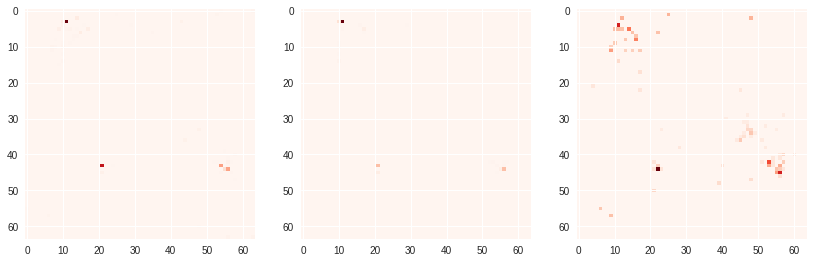

In [15]:
f, ax = plt.subplots(1,3,figsize=(14,6))
for i in range(3):
    ax[i].imshow(X_example[100,i,:,:], cmap="Reds")

In [16]:
del X_example
gc.collect()

85

Load validation data to memory

In [0]:
# This variable tells, how much file pieces of validation data we want to consider
N_DATA_SPLITS = 3

In [0]:
X_val = np.concatenate([np.load("X_val_{}.npy".format(i)) for i in range(N_DATA_SPLITS)])
y_val = np.concatenate([np.load("y_val_{}.npy".format(i)) for i in range(N_DATA_SPLITS)])

## The next steps are exactly the same as on  Monday

In [0]:
from torch import nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

### This is dummy example of CNN, look what you can change here(HINT: look at cifar seminar cheatsheet)

In [0]:
device = torch.device("cuda", 0)

In [21]:
model = torch.nn.Sequential()
model.add_module("maxpool_1", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 32, kernel_size=(5,5), stride=1, padding=0))
model.add_module("maxpool_2", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("relu_1", torch.nn.ReLU())

model.add_module("flat", Flatten())

model.add_module("fc1", torch.nn.Linear(6272, 128))
model.add_module("relu_2", torch.nn.ReLU())
model.add_module("fc2", torch.nn.Linear(128, 1))
model.add_module("sigmoid", torch.nn.Sigmoid())

model.to(device)

Sequential(
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flat): Flatten()
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (relu_2): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Training on minibatches

Just like before, we train our model on small random minibatches of data with adaptive optimization method of your choice.

In [0]:
# An auxilary function that returns mini-batches for neural network training
from tqdm import trange
def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

### Choose you optimiser

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

## And set up batch_size and number of epochs

In [0]:
import time
#from pandas import ewma
from IPython import display

num_epochs = 2 #amount of passes through the data
batch_size = 1024 #number of samples processed at each function call
auc_history = []

number_of_chunks = 3 #number of initial data splits to process
best_score = 0
best_epoch = 0

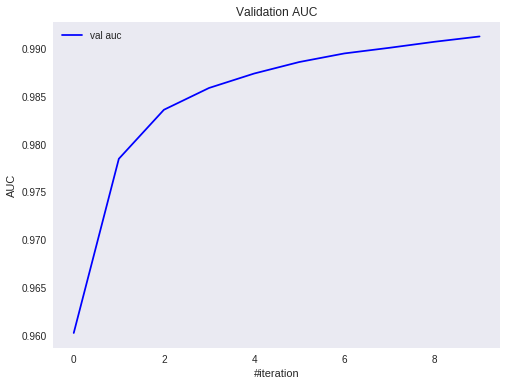

Epoch 8 of 8 took 47.009s
  training loss (in-iteration):		0.115772
  train accuracy:		98.09 %
  validation accuracy:		95.86 %
  validation roc_auc:		99.13 %


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [27]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    
    train_err = train_acc = 0
    train_batches = 0
    start_time = time.time()
    
    for step in range(number_of_chunks):
        X_train, y_train = np.load("X_train_{}.npy".format(step)), np.load("y_train_{}.npy".format(step))
        train_batches += np.ceil(len(X_train) // batch_size)
        # This is you have see already - traning loop
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            X_batch = torch.FloatTensor(X_batch).to(device)
            y_batch = torch.FloatTensor(y_batch).to(device)

            y_predicted = model(X_batch)
            loss = torch.nn.functional.binary_cross_entropy(y_predicted, y_batch).mean()

            loss.backward()
            opt.step()
            opt.zero_grad()

            train_err += loss.data.cpu().numpy()
            train_acc += torch.eq(torch.round(y_predicted), y_batch).data.cpu().numpy().mean()

    # And a full pass over the validation data:
    y_pred = []

    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        X_batch = torch.FloatTensor(X_batch).to(device)
        y_pred.extend(model(X_batch).data.cpu().numpy())

    y_pred = np.asarray(y_pred)
    # Save the metrics values   
    val_acc = accuracy_score(y_val, y_pred > 0.5)
    val_roc_auc = roc_auc_score(y_val, y_pred)
    auc_history.append(val_roc_auc)


    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Validation AUC")
    plt.xlabel("#iteration")
    plt.ylabel("AUC")
    plt.plot(auc_history, 'b',label='val auc')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc * 100))
    print("  validation roc_auc:\t\t{:.2f} %".format(val_roc_auc * 100))
    
    
    if auc_history[-1] > best_score:
        best_score = auc_history[-1]
        best_epoch = epoch
        with open(os.path.join(DATA_PREFIX, "nn_snapshots", "best.pt"), 'wb') as f:
            torch.save(model, f)    

# Read test data, feed it to neural network, and save the output in kaggle fromat.

In [28]:
chunk_size = 10000
test = h5py.File(os.path.join(DATA_PREFIX, "kaggle_test.h5"), 'r')

y_ans = []
for index, step in enumerate(range(0, len(test['all_events']['histHCAL']), chunk_size)):
    X, _ = read_data(test, False, step, step + chunk_size)
    y_ans.extend(model(torch.FloatTensor(X).to(device)).detach().cpu().numpy())
    del X
    gc.collect()
    print("Done:{}".format(index))
    
y_ans = np.array(y_ans)    

Done:0
Done:1
Done:2
Done:3
Done:4
Done:5
Done:6
Done:7
Done:8
Done:9
Done:10
Done:11
Done:12
Done:13


Saving you results to file.

In [0]:
import pandas as pd
from IPython.display import FileLink

def save_results(filename, y_ans):
    answer_dataframe = pd.DataFrame(columns=["ID", "ans"])
    answer_dataframe['ID'] = range(0,len(y_ans))
    answer_dataframe['ans'] = y_ans
    answer_dataframe.to_csv(os.path.join(DATA_PREFIX, '{}'.format(filename)), index=False)
    return FileLink(os.path.join(DATA_PREFIX, '{}'.format(filename)))

In [30]:
save_results("baseline.csv", y_ans)

/content/gdrive/My Drive/kaggle_2/baseline.csv

In [0]:
!kaggle competitions submit -c icl2019-jet -f "{DATA_PATH}/baseline.csv" -m "Message"